In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'facial-emotion-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3525344%2F6232032%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240810%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240810T025746Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D39f138bd46c13700cbd0a394d9c0f3ef8ba83a6b257b9e964ed149af6950ab63bca3badd1937f1a45e79d075929d37e4cd54b3b560e3c1c34560093b25e51ca60ffb38da8f916bb2b6d08702c58101a25d12dc537d89ac36d7d39c127efad6437346b8e0565277847164e1da693f0a1713a07b2545bd10c27ec107d58dbea7aa593d3fc37e00bfe9492143938c3da0bbed4487650e0d16736f681c87e5b13f3fc557e9f9d7214492fa487f2a13ea6f5c7aa4a0e43d919101d36d4b0d88cc03370934946b6d45f9605d7ab87032315aaff847b7aa35dc81372883ce9daae20d33a1e38f4d263f6788a122b0f2ca10b8b6d06c63bebe21cc21975af6c3434ae441'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 454217243 bytes downloaded
Downloaded and uncompressed: facial-emotion-recognition
Data source import complete.


In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [ ]:
# Constants
IMG_SIZE = 48
DATA_DIR = '/kaggle/input/facial-emotion-recognition/images'
EMOTIONS = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Load the dataset
csv_path = '/kaggle/input/facial-emotion-recognition/emotions.csv'
emotions_df = pd.read_csv(csv_path)

In [ ]:
emotions_df['set_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

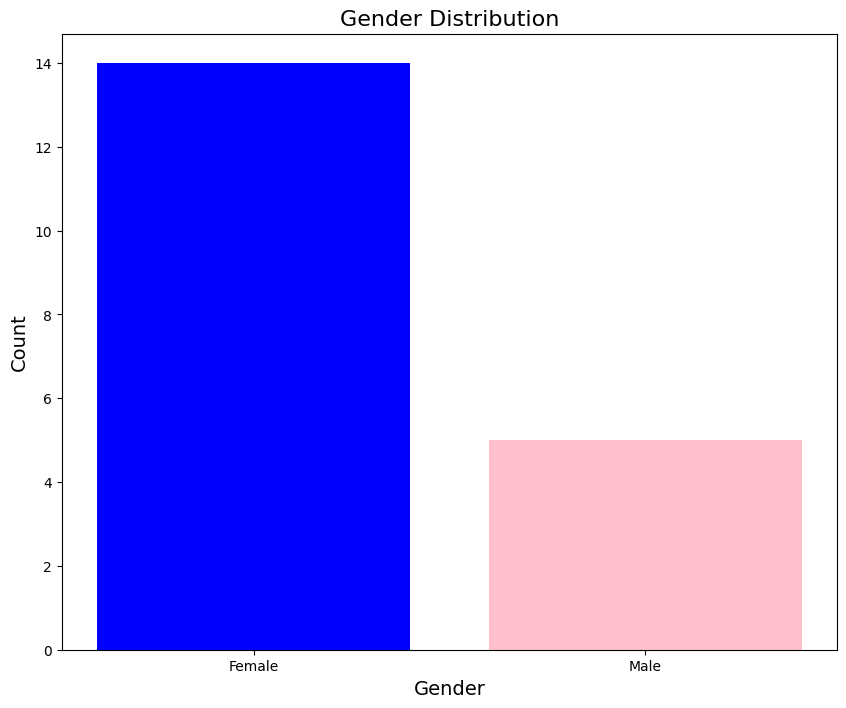

In [ ]:
# Gender distribution
plt.figure(figsize=(10, 8))
gender_counts = emotions_df['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'pink'])
plt.title('Gender Distribution', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

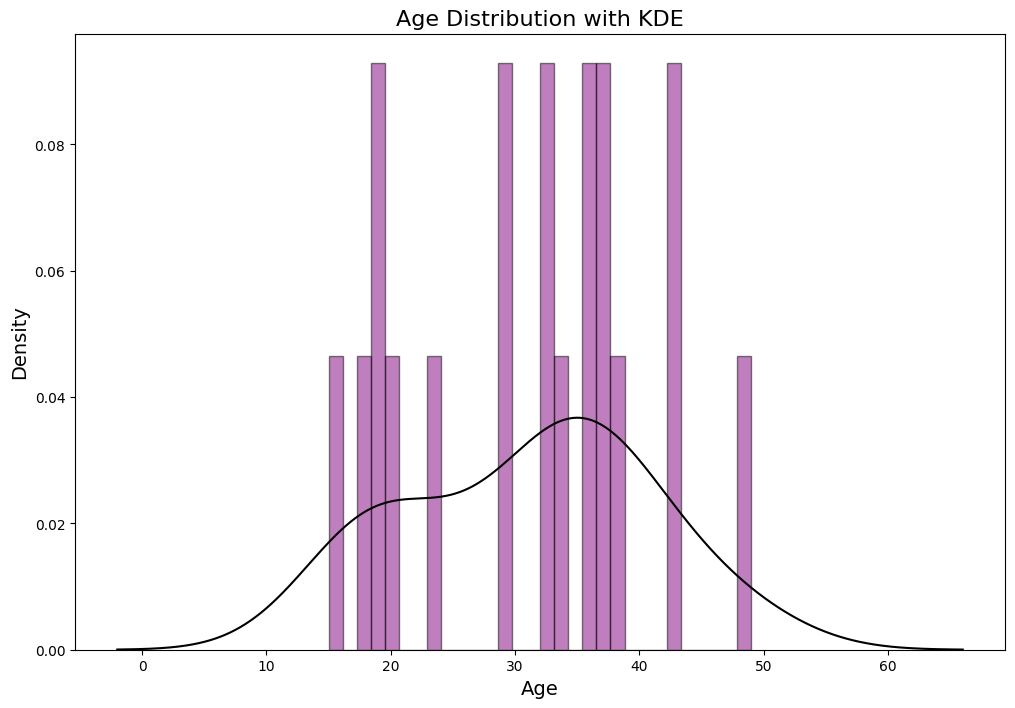

In [ ]:
# Age distribution with KDE
plt.figure(figsize=(12, 8))
emotions_df['age'].plot(kind='hist', bins=30, density=True, alpha=0.5, color='purple', edgecolor='black')
emotions_df['age'].plot(kind='kde', color='black')
plt.title('Age Distribution with KDE', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

<Figure size 1000x800 with 0 Axes>

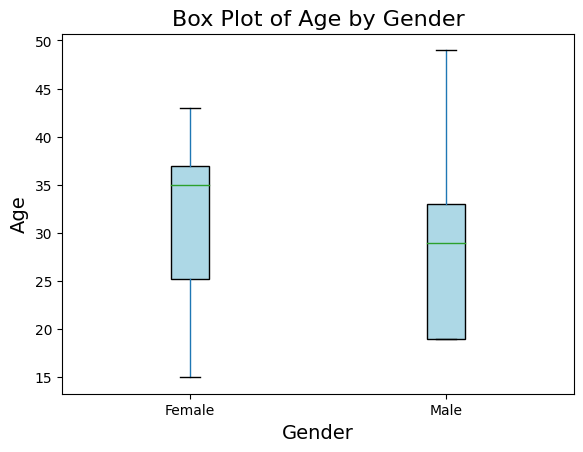

In [ ]:
# Box plot of age by gender
plt.figure(figsize=(10, 8))
emotions_df.boxplot(column='age', by='gender', grid=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Box Plot of Age by Gender', fontsize=16)
plt.suptitle('')
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.xticks([1, 2], ['Female', 'Male'])
plt.show()

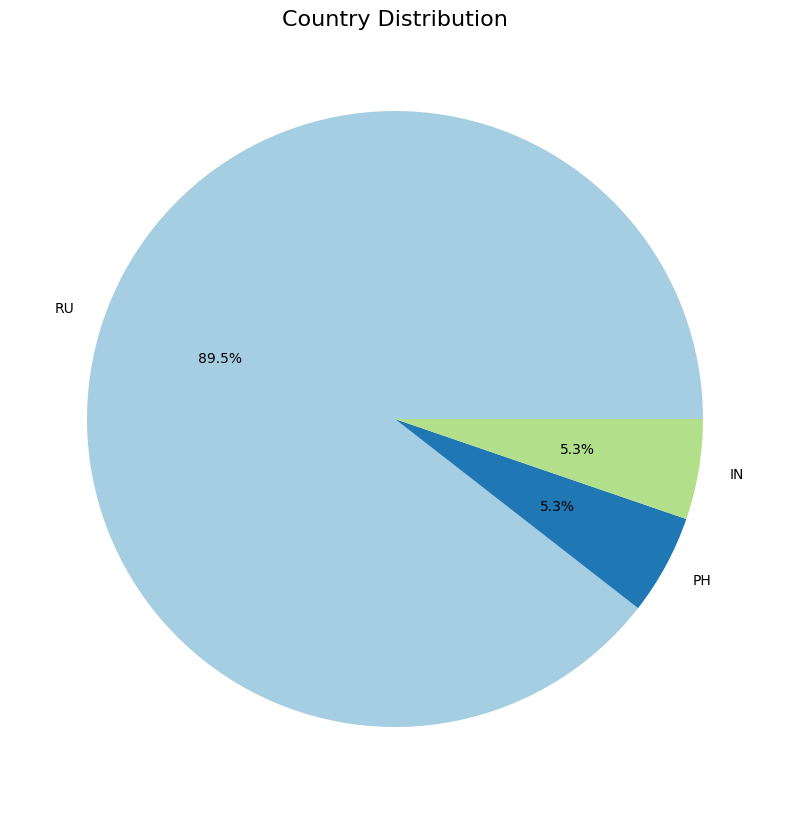

In [ ]:
# Pie chart for country distribution
country_counts = emotions_df['country'].value_counts()
plt.figure(figsize=(12, 10))
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired(np.arange(len(country_counts))))
plt.title('Country Distribution', fontsize=16)
plt.show()

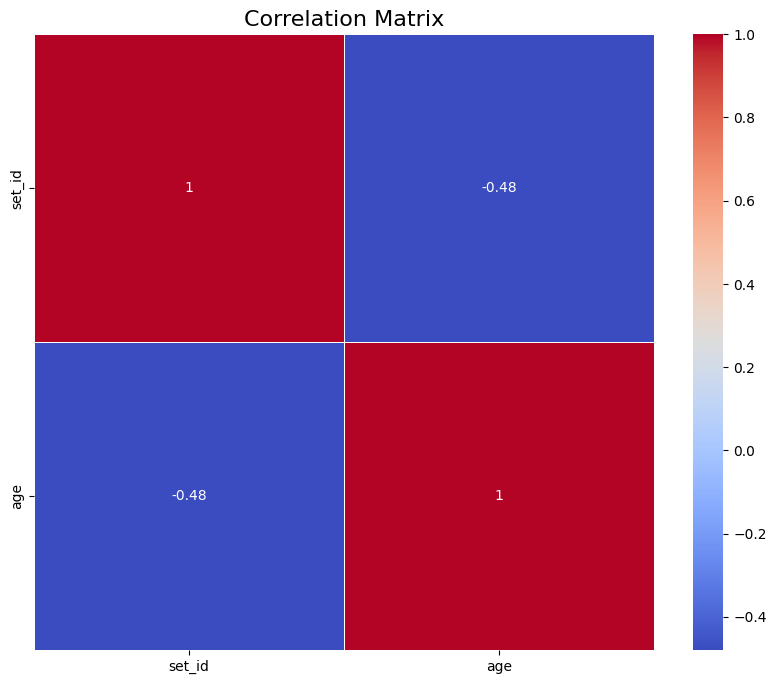

In [ ]:
plt.figure(figsize=(10, 8))
numeric_cols = emotions_df.select_dtypes(include=[np.number])
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [ ]:
# Encode the gender column
label_encoder = LabelEncoder()
emotions_df['gender'] = label_encoder.fit_transform(emotions_df['gender'])

In [ ]:
# Function to load and preprocess images
def load_data():
    images = []
    labels = []

    for emotion_label, emotion in enumerate(EMOTIONS):
        # Get the directory for the current emotion
        emotion_dir = os.path.join(DATA_DIR, str(emotion_label))
        if os.path.isdir(emotion_dir):
            for img_file in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_file)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                images.append(img_resized)
                labels.append(emotion_label)  # Assigning label based on index
        else:
            print(f"Directory not found for emotion {emotion}: {emotion_dir}")

    return np.array(images), np.array(labels)

# Load the data
images, labels = load_data()

In [ ]:
# Normalize images
images = images / 255.0

# Encode labels to categorical
labels_categorical = to_categorical(labels, num_classes=len(EMOTIONS))

In [ ]:
# Check the distribution of the labels to ensure balance
print("Distribution of emotions:")
print(pd.Series(labels).value_counts())

Distribution of emotions:
0    8
1    8
2    8
3    8
4    8
5    8
6    8
7    8
Name: count, dtype: int64


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

In [ ]:
# Reshape for the model
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
# Model Training
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(EMOTIONS), activation='softmax')  # Ensure the correct number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.1070 - loss: 2.0986 - val_accuracy: 0.0769 - val_loss: 2.0797
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1332 - loss: 2.0544 - val_accuracy: 0.0769 - val_loss: 2.0631
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1828 - loss: 2.0239 - val_accuracy: 0.0769 - val_loss: 2.0371
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1932 - loss: 2.0046 - val_accuracy: 0.0769 - val_loss: 2.0025
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2298 - loss: 1.9641 - val_accuracy: 0.0769 - val_loss: 1.9575
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2167 - loss: 1.9608 - val_accuracy: 0.2308 - val_loss: 1.9060
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1855 - loss: 1.9516 - val_accuracy: 0.3846 - val_loss: 1.8181
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3368 - loss: 1.8332 - val_accuracy: 0.3846 - val_loss: 1.7308
Epoch 9/20

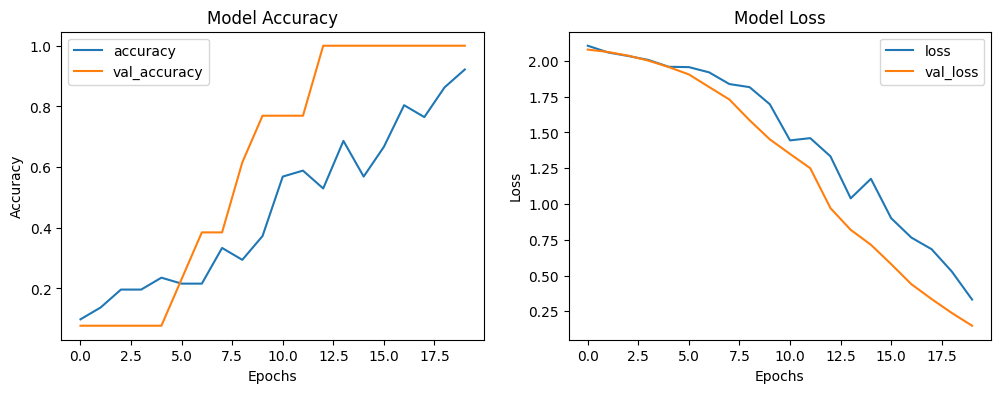

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


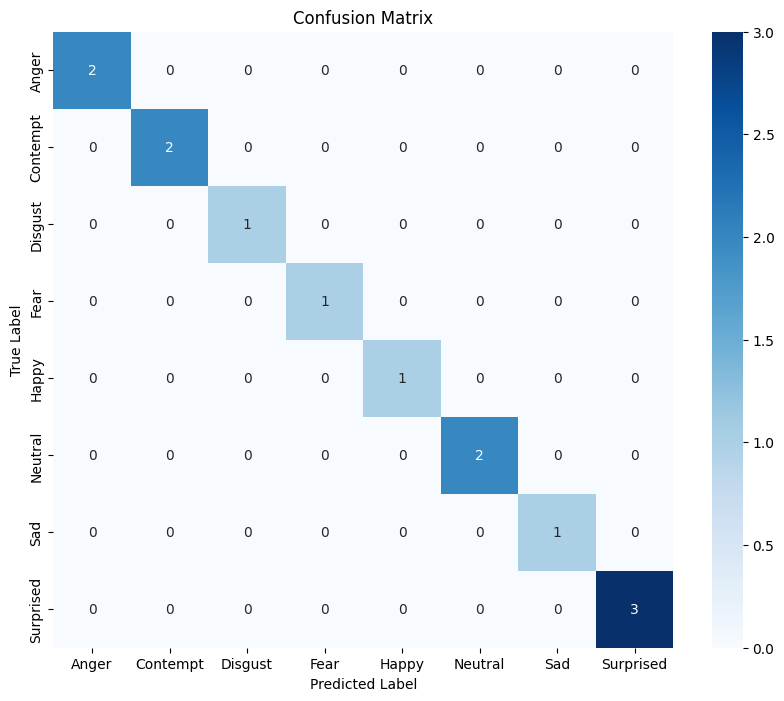

              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00         2
    Contempt       1.00      1.00      1.00         2
     Disgust       1.00      1.00      1.00         1
        Fear       1.00      1.00      1.00         1
       Happy       1.00      1.00      1.00         1
     Neutral       1.00      1.00      1.00         2
         Sad       1.00      1.00      1.00         1
   Surprised       1.00      1.00      1.00         3

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



In [ ]:
# Model Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_df = pd.DataFrame(cm, index=EMOTIONS, columns=EMOTIONS)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=EMOTIONS)
print(report)

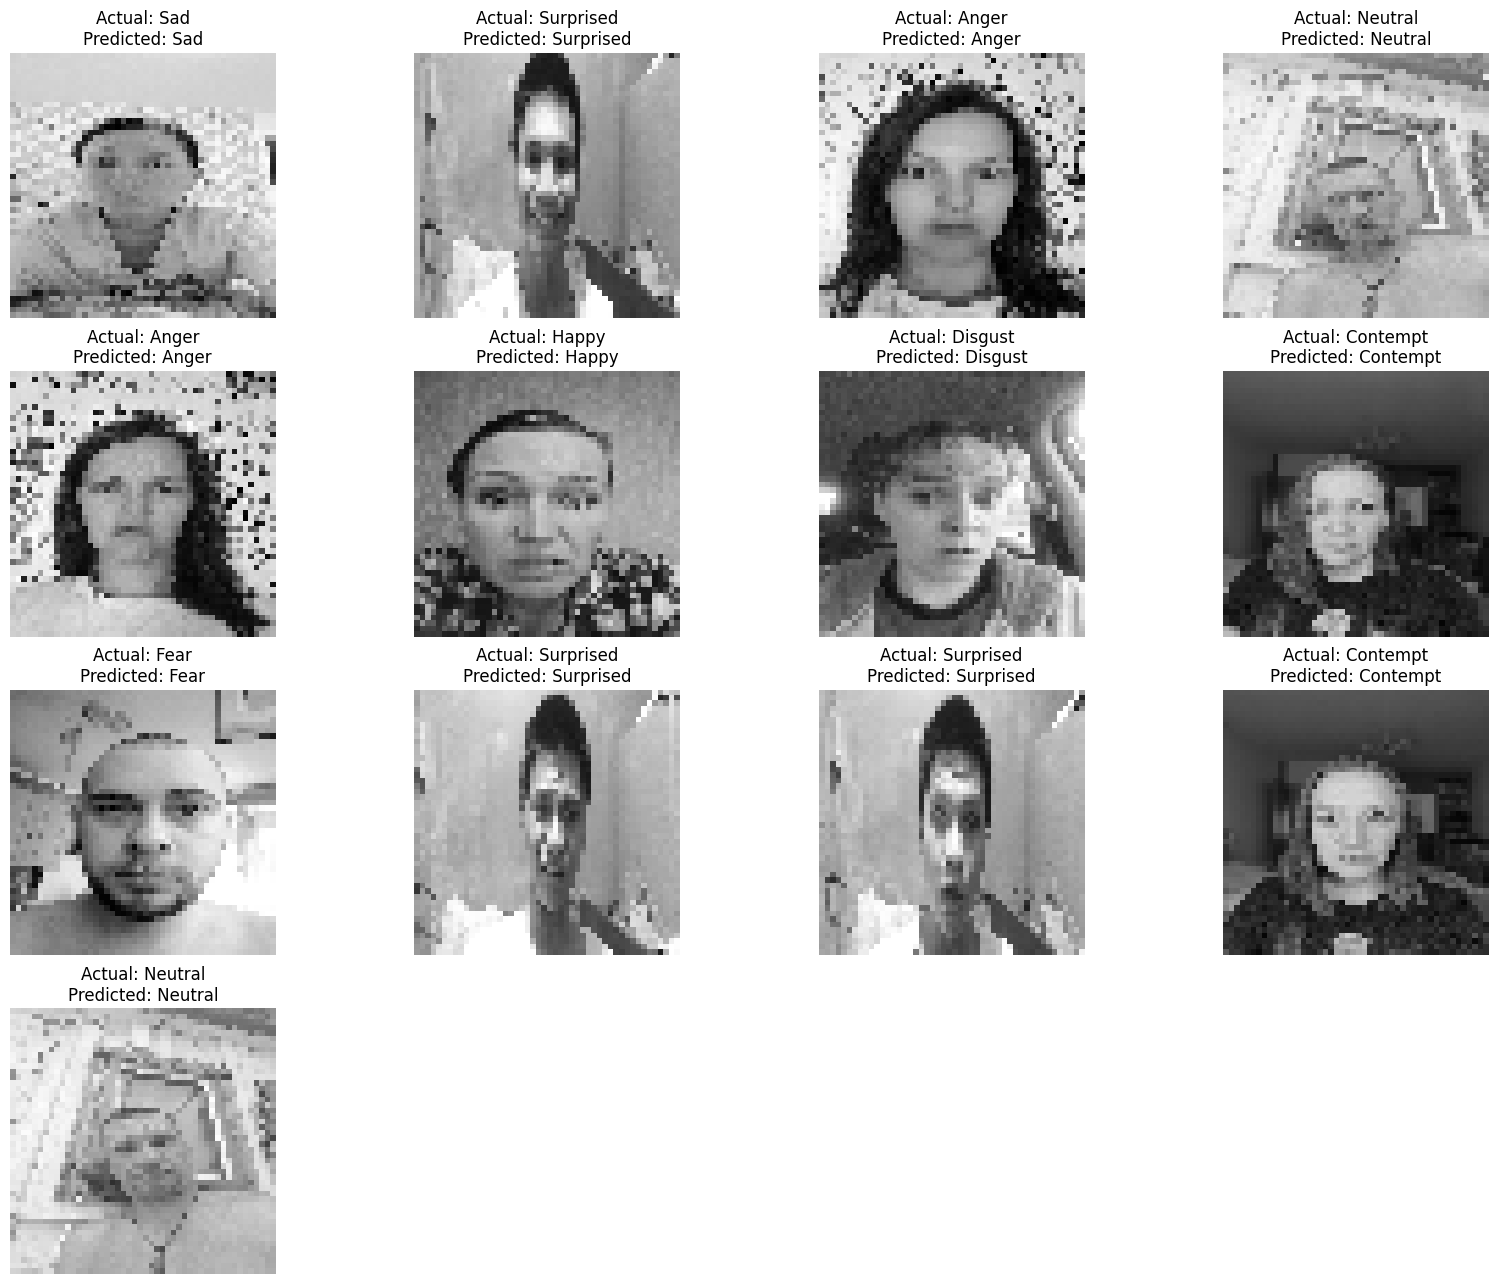

In [ ]:
# Display images with predicted and actual labels
num_images = min(20, len(X_test))
plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(5, 4, i + 1)
    img = (X_test[i] * 255).astype(np.uint8)  # Convert back to uint8
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f"Actual: {EMOTIONS[y_true[i]]}\nPredicted: {EMOTIONS[y_pred_classes[i]]}")
    plt.axis('off')
plt.show()